In [34]:
# Std. lib
from pathlib import Path
# 3rd. party
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, recall_score, f1_score

In [35]:
DATA_PATH = Path('heart.csv')

In [36]:
df = pd.read_csv(DATA_PATH)

cat_cols = ['sex','exng','caa','cp','fbs','restecg','slp','thall']
con_cols = ["age","trtbps","chol","thalachh","oldpeak"]
target_col = ["output"]

df = df[con_cols+target_col]

df0 = df[df['output'] == 0]
df1 = df[df['output'] == 1]

min_data = min(len(df0), len(df1))

sample0 = df0.sample(min_data-1, random_state=0)
sample1 = df1.sample(min_data-1, random_state=0)

df = pd.concat([sample0, sample1]).reset_index()

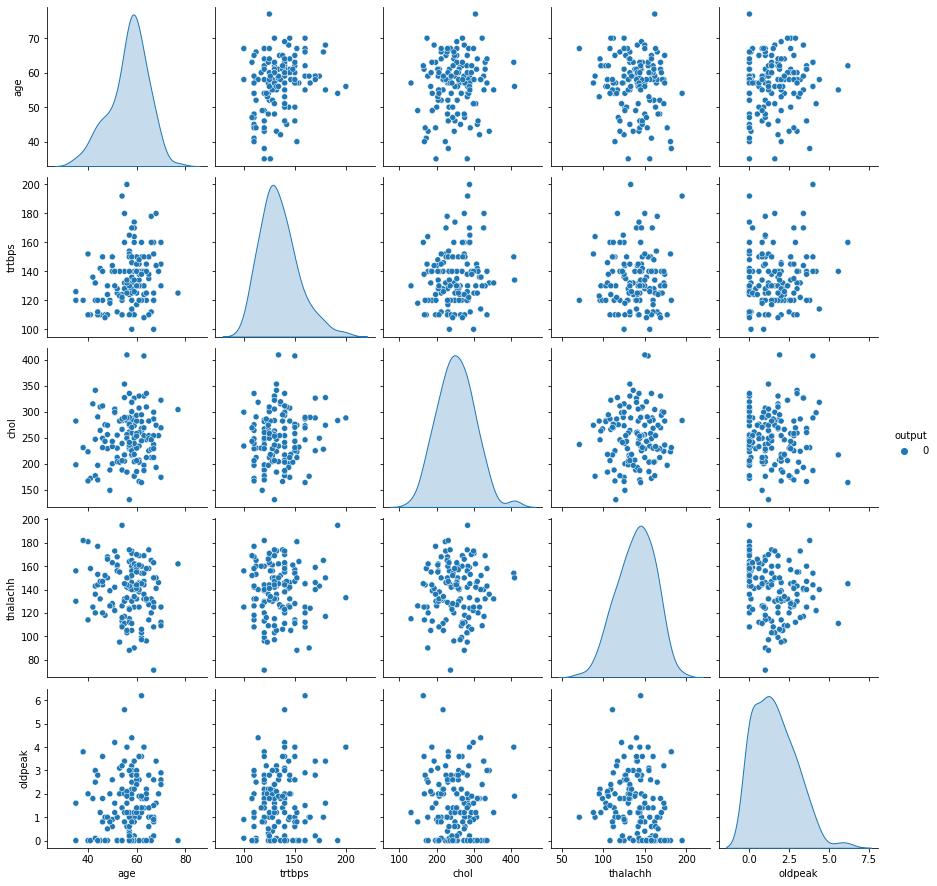

In [37]:
# df.hist(figsize=(15,15))
sns.pairplot(sample0, hue='output')

In [38]:
X = df.loc[:,df.columns != 'output'].to_numpy()
y = df['output'].to_numpy()

In [39]:
p = PCA()
transformed = p.fit_transform(X,y)
cum_var = 0
for i, variance in enumerate(p.explained_variance_ratio_):
    cum_var += variance
    print(f'PC{str(i+1).zfill(2)}: {variance*100:.2f}% ({cum_var*100:.2f}%)')
for i, pc in enumerate(zip(*transformed)):
    df[f"PC{str(i+1).zfill(2)}"] = pc

PC01: 68.68% (68.68%)
PC02: 24.08% (92.75%)
PC03: 4.02% (96.78%)
PC04: 2.70% (99.48%)
PC05: 0.51% (99.99%)
PC06: 0.01% (100.00%)


In [50]:
X_lda = df[['PC01','PC02']].values
l = LDA()
kf = KFold(5, shuffle=True, random_state=0) 
results = []
print("Accuracies:")
for k, fold in enumerate(kf.split(X_lda, y)):
    train_idx, test_idx = fold
    X_train = X_lda[train_idx]
    y_train = y[train_idx]
    X_test = X_lda[test_idx]
    y_test = y[test_idx]

    l.fit(X_train,y_train)
    
    train_prediction = l.predict(X_train)
    test_prediction = l.predict(X_test)
    
    train_acc = accuracy_score(y_train,train_prediction)
    train_recall = recall_score(y_train, train_prediction)
    train_f1 = f1_score(y_train, train_prediction)
    test_acc = accuracy_score(y_test,test_prediction)
    test_recall = recall_score(y_test, test_prediction)
    test_f1 = f1_score(y_test, test_prediction)
    
    print(f"Fold {k+1}: Train Acc: {train_acc*100:>6.2f}%; Rc: {train_recall*100:>6.2f}%; F1: {train_f1*100:>6.2f} | Test Acc: {train_acc*100:>6.2f}%; Rc: {test_acc*100:>6.2f}; F1: {test_f1*100:>6.2f}")
    results.append(((train_acc,train_recall,train_f1),(test_acc,test_recall,test_f1)))
train_results, test_results = zip(*results)
print("Average:")
print(f" * Train:\n    |-> Accuracy: {np.mean(train_results[0])*100:>6.2f}%;\n    |-> Recall: {np.mean(train_results[1])*100:>6.2f}%;\n    |-> F1 Score: {np.mean(train_results[2])*100:>6.2f}")
print(f" * Test:\n    |-> Accuracy: {np.mean(test_results[0])*100:>6.2f}%;\n    |-> Recall: {np.mean(test_results[1])*100:>6.2f}%;\n    |-> F1 Score: {np.mean(test_results[2])*100:>6.2f}")

Accuracies:
Fold 1: Train Acc:  99.54%; Rc:  99.07%; F1:  99.53 | Test Acc:  99.54%; Rc: 100.00; F1: 100.00
Fold 2: Train Acc: 100.00%; Rc: 100.00%; F1: 100.00 | Test Acc: 100.00%; Rc:  96.36; F1:  95.83
Fold 3: Train Acc:  99.09%; Rc:  98.18%; F1:  99.08 | Test Acc:  99.09%; Rc: 100.00; F1: 100.00
Fold 4: Train Acc:  99.54%; Rc:  99.12%; F1:  99.56 | Test Acc:  99.54%; Rc: 100.00; F1: 100.00
Fold 5: Train Acc:  99.09%; Rc:  98.08%; F1:  99.03 | Test Acc:  99.09%; Rc: 100.00; F1: 100.00
Average:
 * Train:
    |-> Accuracy:  99.38%;
    |-> Recall: 100.00%;
    |-> F1 Score:  98.78
 * Test:
    |-> Accuracy: 100.00%;
    |-> Recall:  94.73%;
    |-> F1 Score: 100.00
